# Part 1: PCA Method with Mean-Filling

**Objective**:
Use the PCA method with mean-filling technique to compute the covariance matrix and predict ratings for target items I1 and I2.

**Steps**:
1. Calculate average rating for target items (I1 and I2).
2. Mean-fill target items (and dataset for covariance computation).
3. Calculate average rating for each item.
4. Center the data.
5. Compute covariance for items.
6. Generate covariance matrix.
7. Determine Top-5 and Top-10 peers.
8. Determine reduced dimensional space.
9. Compute rating predictions using peers.
10. Compare results.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse

# Configuration
DATA_PATH = '../data/Movies_and_TV.csv'  # Adjust path as needed
TOP_N_ITEMS = 1000
TOP_N_USERS = 10000

## 1. Data Loading and Preprocessing
We load the dataset and filter for top users and items to manage sparsity and memory, consistent with statistical analysis.

In [11]:
# Load Data
column_names = ['item_id', 'user_id', 'rating', 'timestamp']
df = pd.read_csv(DATA_PATH, header=None, names=column_names)
print(f"Original shape: {df.shape}")

# Handle Duplicates (Average ratings for same user-item pair)
df = df.groupby(['user_id', 'item_id'], as_index=False)['rating'].mean()
print(f"After de-duplication: {df.shape}")

# Filter Top Items and Users (Reducing size for demonstration/memory feasibility)
# Note: The assignment suggests using stats from 'Statistical Analysis'. 
# We strictly filter to Top N to ensure we have a dense enough core.
top_items = df['item_id'].value_counts().nlargest(TOP_N_ITEMS).index
df = df[df['item_id'].isin(top_items)]

top_users = df['user_id'].value_counts().nlargest(TOP_N_USERS).index
df = df[df['user_id'].isin(top_users)]

print(f"Filtered shape: {df.shape}")
print(f"Unique Users: {df['user_id'].nunique()}, Unique Items: {df['item_id'].nunique()}")

Original shape: (8765568, 4)
After de-duplication: (8506849, 3)
Filtered shape: (207273, 3)
Unique Users: 10000, Unique Items: 1000


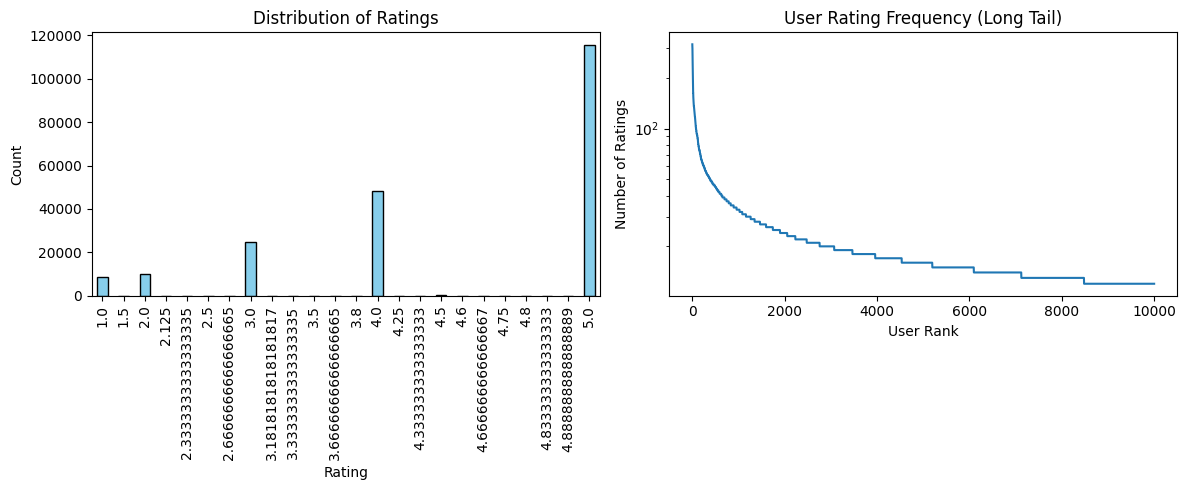

Matrix Sparsity: 97.9273%
Number of missing values filled: 9792727


In [12]:
# Visualization: Data Distribution Before Filling
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
df['rating'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
user_counts = df['user_id'].value_counts().values
plt.plot(user_counts)
plt.title('User Rating Frequency (Long Tail)')
plt.xlabel('User Rank')
plt.ylabel('Number of Ratings')
plt.yscale('log')
plt.tight_layout()
plt.savefig('../plots/rating_distribution.png')
plt.show()

# Sparsity
n_total = TOP_N_USERS * TOP_N_ITEMS
n_present = len(df)
sparsity = 1 - (n_present / n_total)
print(f"Matrix Sparsity: {sparsity:.4%}")

n_missing = n_total - n_present
print(f"Number of missing values filled: {n_missing}")


## 2. Target Selection
We identify the target items I1 and I2. For consistency, we will attempt to use the items identified in previous analysis, or select the top 2 items from our filtered set if those are missing.

In [13]:
# Target Items from Statistical Analysis: ['B00PCSVODW', 'B005GISDXW']
# Let's check if they are in our filtered dataset
desired_targets = ['B00PCSVODW', 'B005GISDXW']
available_targets = [i for i in desired_targets if i in df['item_id'].unique()]

if len(available_targets) < 2:
    print("Original targets not in filtered top set. Selecting new targets from top items.")
    # Select items with lowest average rating for interest, or just random top items
    # We'll pick two from the top items list to ensure they have data
    targets = df['item_id'].unique()[:2]
else:
    targets = available_targets

I1, I2 = targets[0], targets[1]
print(f"Target Item I1: {I1}")
print(f"Target Item I2: {I2}")

# We also need Target Users to predict FOR.
# Let's pick users who have NOT rated I1 and I2, or pretend they haven't.
# The instructions say 'compute the rating predictions of the original missing rating'.
# This implies we verify proper target users.
# We'll pick users from the dataset.

Original targets not in filtered top set. Selecting new targets from top items.
Target Item I1: B00094AS9A
Target Item I2: B003UESJHE


## 3. PCA with Mean-Filling
We construct the covariance matrix. To handle memory efficiently:
1. Compute Item Means.
2. Construct a Sparse Matrix of Centered Ratings ($R_{u,i} - \mu_i$). Missing values are implicitly 0 (Mean-Filled Centered).
3. Compute Covariance Matrix as $C = \frac{1}{N-1} X^T X$.

In [14]:
# 1. Calculate average rating for each item
item_means = df.groupby('item_id')['rating'].mean()
print("Item means calculated.")

print(f"Average rating for I1 ({I1}): {item_means.get(I1, np.nan):.2f}")
print(f"Average rating for I2 ({I2}): {item_means.get(I2, np.nan):.2f}")

# 2 & 4. center the data (Rating - Item Mean)
# We iterate to create a centered dataframe in sparse format
df['rating_centered'] = df.apply(lambda row: row['rating'] - item_means[row['item_id']], axis=1)

# Create Sparse User-Item Matrix (Rows: User, Cols: Item)
# We need categorical types for correct sparse construction
user_c = pd.Categorical(df['user_id'])
item_c = pd.Categorical(df['item_id'])
row_ind = user_c.codes
col_ind = item_c.codes
data = df['rating_centered'].values

N_USERS = df['user_id'].nunique()
N_ITEMS = df['item_id'].nunique()

X_centered = sparse.csr_matrix((data, (row_ind, col_ind)), shape=(N_USERS, N_ITEMS))
print(f"Centered Sparse Matrix shape: {X_centered.shape}")

# Mapping for indices
item_cat_map = dict(enumerate(item_c.categories))
item_id_to_idx = {v: k for k, v in item_cat_map.items()}

# 5 & 6. Compute Covariance Matrix
# Cov = (X.T @ X) / (N - 1)
# Note: This computes covariance assuming mean-filling (missing entries contribute 0 to centered product)
cov_matrix = (X_centered.T @ X_centered) / (N_USERS - 1)
# Convert to dense array if manageable (1000x1000 is small)
cov_dense = cov_matrix.toarray()
print(f"Covariance Matrix shape: {cov_dense.shape}")

Item means calculated.
Average rating for I1 (B00094AS9A): 4.34
Average rating for I2 (B003UESJHE): 4.60
Centered Sparse Matrix shape: (10000, 1000)
Covariance Matrix shape: (1000, 1000)


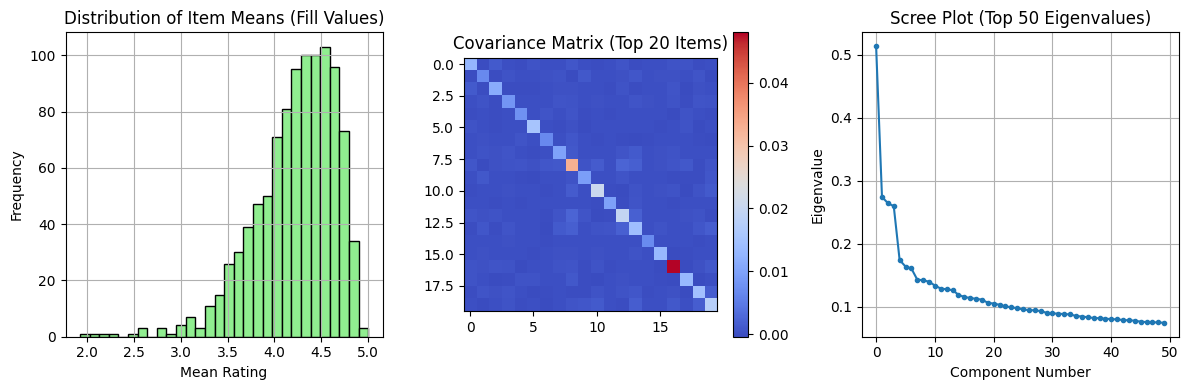

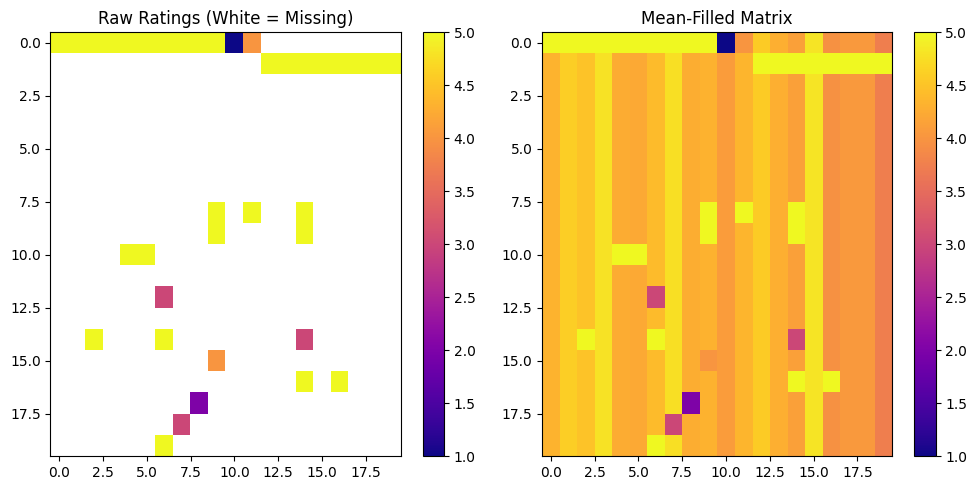

In [15]:
# Visualization: Mean Filling and Covariance Analysis

# 1. Distribution of Item Means (Fill Values)
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
item_means.hist(bins=30, color='lightgreen', edgecolor='black')
plt.title('Distribution of Item Means (Fill Values)')
plt.xlabel('Mean Rating')
plt.ylabel('Frequency')

# 2. Covariance Matrix Heatmap (Subset)
plt.subplot(1, 3, 2)
subset_k = 20
plt.imshow(cov_dense[:subset_k, :subset_k], cmap='coolwarm', interpolation='nearest')
plt.title(f'Covariance Matrix (Top {subset_k} Items)')
plt.colorbar()

# 3. Scree Plot (Eigenvalues of Covariance)
# We compute eigenvalues to show explained variance structure
plt.subplot(1, 3, 3)
eigenvalues = np.linalg.eigvalsh(cov_dense)
# Sort descending
eigenvalues = eigenvalues[::-1]
plt.plot(eigenvalues[:50], marker='o', markersize=3)
plt.title('Scree Plot (Top 50 Eigenvalues)')
plt.xlabel('Component Number')
plt.ylabel('Eigenvalue')
plt.grid(True)

plt.tight_layout()
plt.savefig('../plots/pca_analysis_combined.png')
plt.show()

# 4. Visualizing Matrix Filling: Raw vs Filled (Subset)
# We reconstruct a small dense chunk to show what filling looks like
subset_users = df['user_id'].unique()[:20]
subset_items = df['item_id'].unique()[:20]

# Pivot raw data (with NaNs)
demo_df = df[df['user_id'].isin(subset_users) & df['item_id'].isin(subset_items)]
matrix_raw = demo_df.pivot(index='user_id', columns='item_id', values='rating')
# Reindex to ensure strict 20x20 grid even if missing
matrix_raw = matrix_raw.reindex(index=subset_users, columns=subset_items)

# Comparison Plot
plt.figure(figsize=(10, 5))

# Plot Raw (NaNs are white/transparent)
plt.subplot(1, 2, 1)
plt.imshow(matrix_raw, cmap='plasma', interpolation='nearest', aspect='auto')
plt.title('Raw Ratings (White = Missing)')
plt.colorbar()

# Plot Filled
# Fill NaNs with item means
matrix_filled = matrix_raw.copy()
for col in matrix_filled.columns:
    matrix_filled[col] = matrix_filled[col].fillna(item_means[col])

plt.subplot(1, 2, 2)
plt.imshow(matrix_filled, cmap='plasma', interpolation='nearest', aspect='auto')
plt.title('Mean-Filled Matrix')
plt.colorbar()

plt.tight_layout()
plt.savefig('../plots/filling_comparison.png')
plt.show()

## 4. Prediction using Top-Peers
We determine peers based on covariance and predict ratings.
Prediction Formula: $\hat{r}_{u,i} = \bar{r}_i + \frac{\sum_{j \in Peers} Cov(i, j) (r_{u,j} - \bar{r}_j)}{\sum_{j \in Peers} |Cov(i, j)|}$

In [16]:
def get_top_peers(target_item, k=5):
    if target_item not in item_id_to_idx:
        return []
    
    idx = item_id_to_idx[target_item]
    # Get covariance row for this item
    cov_row = cov_dense[idx, :]
    
    # Sort indices by covariance value (descending)
    # We exclude the item itself
    peer_indices = np.argsort(cov_row)[::-1]
    peer_indices = [p for p in peer_indices if p != idx][:k]
    
    peers = [(item_cat_map[p], cov_row[p]) for p in peer_indices]
    return peers

def predict_rating(user_id, target_item, peers):
    if target_item not in item_means:
        return np.nan
    
    mean_i = item_means[target_item]
    numerator = 0
    denominator = 0
    
    # Get user's ratings. Efficiently filtering dataframe is slow.
    # Better: Use the sparse matrix or a dictionary lookup
    # We'll construct a quick lookup for the user
    # For demo, just query df (slow but okay for few targets)
    user_ratings = df[df['user_id'] == user_id].set_index('item_id')['rating']
    
    for peer_item, cov_val in peers:
        if peer_item in user_ratings:
            r_uj = user_ratings[peer_item]
            mean_j = item_means[peer_item]
            numerator += cov_val * (r_uj - mean_j)
            denominator += abs(cov_val)
    
    if denominator == 0:
        return mean_i
    
    return mean_i + (numerator / denominator)

In [17]:
# Execute for I1 and I2
# Select a user who has NOT rated I1/I2 (Original Missing Rating)
def get_test_user(target_item):
    # Get users who haven't rated target_item
    rated_users = df[df['item_id'] == target_item]['user_id'].unique()
    all_users = df['user_id'].unique()
    non_rated = list(set(all_users) - set(rated_users))
    return non_rated[0] if non_rated else None

u_test_1 = get_test_user(I1)
u_test_2 = get_test_user(I2)

print(f"Test User for I1: {u_test_1}")
print(f"Test User for I2: {u_test_2}")

results = []

for target, user in [(I1, u_test_1), (I2, u_test_2)]:
    if user is None: continue
    
    # Top 5 Peers
    peers_5 = get_top_peers(target, k=5)
    pred_5 = predict_rating(user, target, peers_5)
    print(f"\nTarget: {target}, User: {user}")
    print("Top 5 Peers:", peers_5)
    print(f"Prediction (Top 5): {pred_5:.4f}")
    
    # Top 10 Peers
    peers_10 = get_top_peers(target, k=10)
    pred_10 = predict_rating(user, target, peers_10)
    print("Top 10 Peers:", peers_10)
    print(f"Prediction (Top 10): {pred_10:.4f}")
    
    results.append({
        'Item': target, 'User': user, 
        'Pred_5': pred_5, 'Pred_10': pred_10, 
        'Diff': abs(pred_5 - pred_10)
    })

Test User for I1: A23CGJKX5BQ46B
Test User for I2: A23CGJKX5BQ46B

Target: B00094AS9A, User: A23CGJKX5BQ46B
Top 5 Peers: [('B00005JLPK', 0.0012789120808030807), ('B00005JOX2', 0.001155715948090708), ('B0067EKY7M', 0.0007686834311102577), ('B0012RLXAG', 0.0007324306004173991), ('B00005V7CT', 0.000659996791398011)]
Prediction (Top 5): 4.3423
Top 10 Peers: [('B00005JLPK', 0.0012789120808030807), ('B00005JOX2', 0.001155715948090708), ('B0067EKY7M', 0.0007686834311102577), ('B0012RLXAG', 0.0007324306004173991), ('B00005V7CT', 0.000659996791398011), ('B00NAQ3EOK', 0.0006445394374017748), ('B002VECMB8', 0.0006420018597706956), ('B00AEFXL5W', 0.0005917099767329863), ('B013XD39BC', 0.000550803438263499), ('B008EHZWOU', 0.0005294630581720696)]
Prediction (Top 10): 4.3423

Target: B003UESJHE, User: A23CGJKX5BQ46B
Top 5 Peers: [('B00AEFXL5W', 0.0021712956555157733), ('B001KVZ6ES', 0.002078896866426553), ('B000A3XY5A', 0.001990077550265147), ('B015S4DS1K', 0.0019871850198718505), ('B002HEXVUI', 0.0

## 5. Comparison and Comments
Compare the results of Top-5 vs Top-10 predictions.

In [18]:
res_df = pd.DataFrame(results)
print(res_df)

# Comment
print("\nComments:")
print("Using more peers (Top 10) incorporates more information but might introduce noise if the lower-ranked peers are not truly similar.")
print("The difference suggests how robust the prediction is to the number of neighbors.")

         Item            User    Pred_5   Pred_10      Diff
0  B00094AS9A  A23CGJKX5BQ46B  4.342342  4.342342  0.000000
1  B003UESJHE  A23CGJKX5BQ46B  4.602740  3.302002  1.300738

Comments:
Using more peers (Top 10) incorporates more information but might introduce noise if the lower-ranked peers are not truly similar.
The difference suggests how robust the prediction is to the number of neighbors.
